In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from match_image_data import convert_csv_2_dict, load_images_from_folder, get_drone_state



DATAFILE_DRONE = "/home/matthijs/paparazzi/data/AE4317_2019_datasets/cyberzoo_aggressive_flight/20190121-144708.csv"
IMAGES_FOLDER = "/home/matthijs/paparazzi/data/AE4317_2019_datasets/cyberzoo_aggressive_flight/20190121-144646/"
VIDEO_FILE = "/home/matthijs/robotics_q3/mav/cyberzoo.mp4"
VIDEO_FILE_SIM = "/home/matthijs/paparazzi/videos/vlc-record-2023-03-03-11h21m26s-rtp_5000.sdp-.avi"
VIDEO_ALL_OBSTACLES = "/home/matthijs/paparazzi/videos/vlc-record-2023-03-10-10h06m31s-rtp_5000.sdp-.avi"
VIDEO_ORANGE_AVOID = "/home/matthijs/paparazzi/videos/vlc-record-2023-03-10-09h59m06s-rtp_5000.sdp-.avi"
SHOW_CV2_IMG = False
SHOW_VIDEO = True

drone_state_dict = convert_csv_2_dict(DATAFILE_DRONE)
images_cyberzoo_dict = load_images_from_folder(IMAGES_FOLDER)
images_cyberzoo = images_cyberzoo_dict["images"]
images_cyberzoo_stamp = images_cyberzoo_dict["timestamps"]

In [13]:
!pip install opencv-python
!pip install pandas

     |████████████████████████████████| 12.2 MB 4.9 MB/s eta 0:00:01
     |████████████████████████████████| 17.3 MB 14.3 MB/s eta 0:00:01    |██████████████████▎             | 9.9 MB 61.2 MB/s eta 0:00:01
     |████████████████████████████████| 502 kB 18.8 MB/s eta 0:00:01


In [3]:
def show_img(img, gray_scale=False, img_name="img"):
    if SHOW_CV2_IMG:
        cv2.imshow(img_name, img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        if gray_scale:
            cmap = "gray"
        else:
            cmap = None
        plt.imshow(img, cmap=cmap)


In [4]:
def rgb_2_gray(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray


In [28]:
# This Optical flow implementation yields to way better results
import time
from collections import deque


def draw_flow(img, flow, step=16):

    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T

    lines = np.vstack([x, y, x-fx, y-fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)

    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(img_bgr, lines, 0, (0, 255, 0))

    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(img_bgr, (x1, y1), 1, (0, 255, 0), -1)

    return img_bgr


def draw_hsv(flow):

    h, w = flow.shape[:2]
    fx, fy = flow[:,:,0], flow[:,:,1]

    ang = np.arctan2(fy, fx) + np.pi
    v = np.sqrt(fx*fx+fy*fy)

    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[...,0] = ang*(180/np.pi/2)
    hsv[...,1] = 255
    hsv[...,2] = np.minimum(v*4, 255)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return bgr

def draw_flow_sides(flow_left, flow_right):
    img_flow_sides = np.zeros((200, 50))
    img_flow_sides[:100, :] = flow_left
    img_flow_sides[100:, :] = flow_right
    return img_flow_sides




if SHOW_VIDEO:

    cap = cv2.VideoCapture(VIDEO_ORANGE_AVOID)

    suc, prev = cap.read()

    prev = prev[160:360,95:145]
    prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
    #prevgray = canny_edge_detection(prevgray)
    flow_left_queue = deque(maxlen=3)
    flow_right_queue = deque(maxlen=3)
    while True:

        suc, img = cap.read()
        if img is None:
            continue 
        img = img[160:360,95:145]
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #gray = canny_edge_detection(gray)
        # start time to calculate FPS
        start = time.time()
        print("hi", prevgray[:100,:].shape)
        flow_l = cv2.calcOpticalFlowFarneback(prevgray[:100,:], gray[:100,:], None, 0.5, 3, 15, 3, 5, 1.2, 0)
        flow_r = cv2.calcOpticalFlowFarneback(prevgray[100:,:], gray[100:,:], None, 0.5, 3, 15, 3, 5, 1.2, 0)
        print(flow_l.shape)
        flow_left = np.sum(np.linalg.norm(flow_l, axis=2))
        flow_right = np.sum(np.linalg.norm(flow_r, axis=2))
        print(flow_left.shape, flow_right.shape)
        flow_left_queue.append(flow_left)
        flow_right_queue.append(flow_right)
        sum_flow_left = np.sum(flow_left_queue)
        sum_flow_right = np.sum(flow_right_queue)
        print(sum_flow_left, sum_flow_right)
        flow_left_norm = sum_flow_left / max(sum_flow_left, sum_flow_right)
        flow_right_norm = sum_flow_right / max(sum_flow_left, sum_flow_right)

        # print(flow_left_norm, flow_right_norm)
        prevgray = gray


        # End time
        end = time.time()
        # calculate the FPS for current frame detection
        fps = 1 / (end-start)

        print(f"{fps:.2f} FPS")

        #cv2.imshow('flow', draw_flow(gray, flow))
        cv2.imshow('flow sides', draw_flow_sides(flow_left_norm, flow_right_norm))
        #cv2.imshow('flow HSV', draw_hsv(flow))


        key = cv2.waitKey(1000)
        if key == ord('q'):
            break


    cap.release()
    cv2.destroyAllWindows()


hi (100, 50)
(100, 50, 2)
() ()
2605.4631 2470.5425
376.95 FPS
hi (100, 50)
(100, 50, 2)
() ()
4795.7495 5320.7305
518.71 FPS
hi (100, 50)
(100, 50, 2)
() ()
8141.8174 8288.392
408.48 FPS
hi (100, 50)
(100, 50, 2)
() ()
7851.1523 8263.01
612.75 FPS
hi (100, 50)
(100, 50, 2)
() ()
8295.564 8205.986
361.61 FPS
hi (100, 50)
(100, 50, 2)
() ()
7308.2197 8005.0513
588.26 FPS


In [70]:
# images_folder = "/home/matthijs/paparazzi/data/AE4317_2019_datasets/cyberzoo_poles_panels_mats/20190121-142935"

# from os import walk

# images = []
# for (dirpath, dirnames, filenames) in walk(images_folder):
#     images.extend(filenames)
#     break
# images=np.sort(images)
# print(images)

In [84]:
import csv
class Obstacle:
    def __init__(self, x, y):
        self.x = x
        self.y = y

pole_loc_file = "/home/matthijs/paparazzi/data/AE4317_2019_datasets/cyberzoo_poles_panels_mats/pole_locations.csv"
real_obs = []
iter = 0
fn = open(pole_loc_file, "r")
file = csv.DictReader(fn)
x_list = []
y_list = []
for col in file:
    x_list.append(float(col['x']))
    y_list.append(float(col['y']))
print(x_list, y_list)

for i in range(len(x_list)):
    real_obs.append(Obstacle(x_list[i], y_list[i]))




[-1.9, -0.15, 0.3, 0.2] [-0.05, 3.6, 0.4, -3.3]


In [76]:

from match_image_data import convert_csv_2_dict, load_images_from_folder, get_drone_state

DATAFILE_DRONE = "/home/matthijs/paparazzi/data/AE4317_2019_datasets/cyberzoo_poles_panels_mats/20190121-142943.csv"
IMAGES_FOLDER = "/home/matthijs/paparazzi/data/AE4317_2019_datasets/cyberzoo_poles_panels_mats/20190121-142935"


drone_state_dict = convert_csv_2_dict(DATAFILE_DRONE)
images_cyberzoo_dict = load_images_from_folder(IMAGES_FOLDER)
images = images_cyberzoo_dict["images"]
images_stamp = images_cyberzoo_dict["timestamps"]
print(drone_state_dict)

{'time': array([ 9.672515,  9.680317,  9.690085, ..., 71.176384, 71.18615 ,
       71.195915]), 'pos_x': array([-1.917969, -1.917969, -1.917969, ...,  1.707031,  1.707031,
        1.707031]), 'pos_y': array([-1.308594, -1.308594, -1.308594, ..., -0.117188, -0.117188,
       -0.117188]), 'pos_z': array([0.      , 0.      , 0.      , ..., 0.058594, 0.058594, 0.058594]), 'vel_x': array([0., 0., 0., ..., 0., 0., 0.]), 'vel_y': array([0., 0., 0., ..., 0., 0., 0.]), 'vel_z': array([-0.054461, -0.051746, -0.052757, ..., -0.002436, -0.0019  ,
       -0.002016]), 'att_phi': array([ 0.008484,  0.008423,  0.008423, ..., -0.03598 , -0.03598 ,
       -0.03598 ]), 'att_theta': array([ 0.006348,  0.006348,  0.006348, ..., -0.031255, -0.031255,
       -0.031255]), 'att_psi': array([0.03376 , 0.033821, 0.033821, ..., 0.494243, 0.494243, 0.494243]), 'rate_p': array([ 0.000244,  0.000244,  0.002441, ...,  0.000732, -0.000977,
       -0.000488]), 'rate_q': array([-0.000732, -0.000244,  0.000244, ..., -0.0

In [139]:
import cv2
from collections import deque

WIDTH = 30
HEIGHT = 140
LEFT = 0
MIDDLE = 1
RIGHT = 2
MAX_RANGE = 6
FOV = 70*np.pi/180

# FLOWMIDDLE_DIV_LOWER = 0.6
# RIGHT_OBS_TH = 0.75
# LEFT_OBS_TH = 1.3
# FLOWMIDDLE_DIV_UPPER = 1.4



def create_windows(whole_window, width, height):
    left_window = whole_window[:int(height/2), :width, :]
    middle_window = whole_window[int(height/4):int(3*height/4), :width, :]
    right_window = whole_window[int(height/2):height, :width, :]
    return left_window, middle_window, right_window

def scale_window(whole_window, width, height):
    img_shape = img.shape
    width_img = img_shape[1]
    height_img = img_shape[0]
    scaled_window = whole_window[int(height_img/2 - height/2):int(height_img/2 + height/2), int(width_img/2 - width/2):int(width_img/2 + width/2)]
    return scaled_window

def calculate_output_flow(flow):
    return np.sum(np.linalg.norm(flow, axis=2))

def obs_detection(flow_left, flow_right, flow_middle, flow_middle_prev):
    obs = []
    if flow_left/flow_right > LEFT_OBS_TH:
        obs.append(LEFT)
    if flow_middle/flow_middle_prev > FLOWMIDDLE_DIV_UPPER or flow_middle/flow_middle_prev < FLOWMIDDLE_DIV_LOWER:
        obs.append(MIDDLE)
    if flow_left/flow_right < RIGHT_OBS_TH:
        obs.append(RIGHT)
    return obs

def obstacle_in_range(x_drone, y_drone, yaw_drone, real_obs, max_range=5):
    obstacle_pos_list = []
    for j, obs in enumerate(real_obs):
        if (obs.x - x_drone)**2 + (obs.y - y_drone)**2 > max_range**2:
            obstacle_pos_list.append(-1)
            continue
        tf_x = (obs.x - x_drone) * np.cos(yaw_drone) + (obs.y - y_drone) * np.sin(yaw_drone)
        tf_y = (obs.y - y_drone) * np.cos(yaw_drone) - (obs.x - x_drone) * np.sin(yaw_drone)
        # print(f"{j}:", tf_x, tf_y)
        angle = np.arctan(tf_y/tf_x)
        if abs(angle) > FOV/2:
            obstacle_pos_list.append(-1)
            continue
        if angle > 0:
            obstacle_pos_list.append(RIGHT)
        else:
            obstacle_pos_list.append(LEFT)
        if abs(angle) < FOV/4:
            obstacle_pos_list.append(MIDDLE)
    return obstacle_pos_list

# def adapt_conf_mat(conf_mat, obstacle_pos_list, detected_obstacles):
#     conf_mat_copy = np.copy(conf_mat)
#     no_obs = False
#     for obs_pos in obstacle_pos_list:
#         if np.max(obs_pos)==-1:
#             no_obs = True
#             break
#         if obs_pos ==-1:
#             continue
#         elif obs_pos in detected_obstacles:
#             conf_mat_copy[0,0]+=1
#         else:
#             conf_mat_copy[1,0]+=1
#     if len(detected_obstacles) == 0 and no_obs:
#         conf_mat_copy[1,1]+=1
#     else:
#         for obs in detected_obstacles:
#             if obs not in obstacle_pos_list:
#                 conf_mat_copy[0,1]+=1
#     return conf_mat_copy

def adapt_conf_mat(conf_mat, obstacle_pos_list, detected_obstacles):
    conf_mat_copy = np.copy(conf_mat)
    if (np.max(obstacle_pos_list)==-1) and (len(detected_obstacles)==0):
        conf_mat_copy[1,1]+=1
    elif (np.max(obstacle_pos_list)>-1) and (len(detected_obstacles)==0):
        conf_mat_copy[1,0]+=1
    if (np.max(obstacle_pos_list)==-1) and (len(detected_obstacles)>0):
        conf_mat_copy[0,1]+=1
    if (np.max(obstacle_pos_list)>-1) and (len(detected_obstacles)>0):
        conf_mat_copy[0,0]+=1
    return conf_mat_copy
tpr_l = []
fpr_l = []
for i1 in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    for j1 in [1.0, 1.2, 1.5, 1.8, 2.2, 2.8]:
        for k1 in [1.0, 1.2, 1.5, 1.8, 2.2, 2.8]:
            FLOWMIDDLE_DIV_LOWER = i1
            LEFT_OBS_TH = j1
            RIGHT_OBS_TH = 1/LEFT_OBS_TH

            FLOWMIDDLE_DIV_UPPER = k1

            flow_left_queue = deque(maxlen=3)
            flow_right_queue = deque(maxlen=3)
            flow_middle_queue = deque(maxlen=3)
            conf_mat = np.zeros((2,2))
            
            for i, img in enumerate(images):
                # img = cv2.imread(f"{images_folder}/{img_f}")
                # cv2.imshow("img", img)
                scaled_img = scale_window(img, WIDTH, HEIGHT)
                cv2.imshow("img", scaled_img)
                img_grey = cv2.cvtColor(scaled_img, cv2.COLOR_BGR2GRAY)
                if i==0:
                    prev_grey = np.copy(img_grey)
                    continue
                flow = cv2.calcOpticalFlowFarneback(prev_grey[:,:], img_grey[:,:], None, 0.5, 3, 15, 3, 5, 1.2, 0)
                flow_l, flow_m, flow_r = create_windows(flow, WIDTH, HEIGHT)
                flow_left_queue.append(calculate_output_flow(flow_l))
                flow_right_queue.append(calculate_output_flow(flow_r))
                flow_middle_queue.append(calculate_output_flow(flow_m))
                flow_left = np.sum(flow_left_queue)
                flow_right = np.sum(flow_right_queue)
                flow_middle = np.sum(flow_middle_queue)
                if i ==1:
                    flow_middle_prev = flow_middle
                
                detected_obs = obs_detection(flow_left, flow_right, flow_middle, flow_middle_prev)
                #print(img.shape)
            
                drone_state = get_drone_state(drone_state_dict, images_stamp[i])
                x_drone = drone_state["pos_x"]
                y_drone = drone_state["pos_y"]
                yaw_drone = drone_state["att_psi"]  #+ np.pi/4
                # print("pos: ", x_drone, y_drone, yaw_drone)
                obs_pos_list = obstacle_in_range(x_drone, y_drone, yaw_drone, real_obs, MAX_RANGE)
                conf_mat = adapt_conf_mat(conf_mat, obs_pos_list, detected_obs)
                flow_middle_prev = flow_middle
                prev_grey = np.copy(img_grey)
                key = cv2.waitKey(1)
                if key == ord('q'):
                    break  
            cv2.destroyAllWindows()
            print(conf_mat) 
            tpr = conf_mat[0,0]/(conf_mat[0,0] + conf_mat[1,0])
            fpr = 1 - conf_mat[1,1]/(conf_mat[1,1]+conf_mat[0,1])
            tpr_l.append(tpr)
            fpr_l.append(fpr)
            print(f"tpr: {tpr}, fpr: {fpr}")



[[350. 121.]
 [  0.   0.]]
tpr: 1.0, fpr: 1.0
[[350. 121.]
 [  0.   0.]]
tpr: 1.0, fpr: 1.0
[[350. 121.]
 [  0.   0.]]
tpr: 1.0, fpr: 1.0
[[350. 121.]
 [  0.   0.]]
tpr: 1.0, fpr: 1.0
[[350. 121.]
 [  0.   0.]]
tpr: 1.0, fpr: 1.0
[[350. 121.]
 [  0.   0.]]
tpr: 1.0, fpr: 1.0
[[335. 106.]
 [ 15.  15.]]
tpr: 0.9571428571428572, fpr: 0.8760330578512396
[[320.  99.]
 [ 30.  22.]]
tpr: 0.9142857142857143, fpr: 0.8181818181818181
[[319.  95.]
 [ 31.  26.]]
tpr: 0.9114285714285715, fpr: 0.7851239669421488
[[316.  94.]
 [ 34.  27.]]
tpr: 0.9028571428571428, fpr: 0.7768595041322314
[[315.  94.]
 [ 35.  27.]]
tpr: 0.9, fpr: 0.7768595041322314
[[315.  93.]
 [ 35.  28.]]
tpr: 0.9, fpr: 0.768595041322314
[[323.  93.]
 [ 27.  28.]]
tpr: 0.9228571428571428, fpr: 0.768595041322314
[[302.  75.]
 [ 48.  46.]]
tpr: 0.8628571428571429, fpr: 0.6198347107438016
[[298.  69.]
 [ 52.  52.]]
tpr: 0.8514285714285714, fpr: 0.5702479338842975
[[295.  67.]
 [ 55.  54.]]
tpr: 0.8428571428571429, fpr: 0.5537190082644

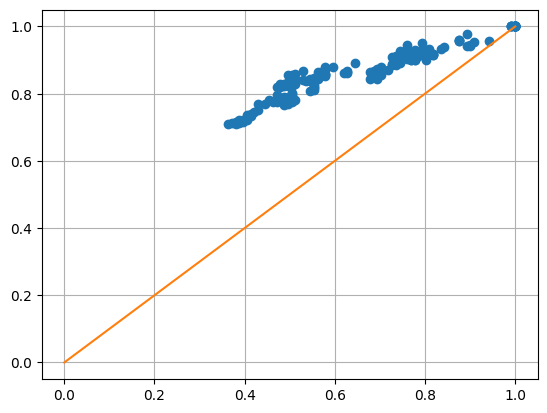

In [140]:
import matplotlib.pyplot as plt
y = np.linspace(0,1,100)
x = y
plt.plot(fpr_l, tpr_l, "o")
plt.plot(x, y)
plt.grid()
plt.show()